`get_data(filepath)`: get the dataset  

`sum_norm(df)`: sum normailise the dataset 

`get_valid_subset(norm_df)`: get the subset that contains valid content in the answers 

`problem_processing(subset['Problem'])`: processing the problem text in the normalised valid subset

`separate_text(problems)`: separate the text in the problems

`separate_numbers(problems)`: separate the numbers in the problems

`text_process(text)`: process text and show the distribution of text sequence

`pad_text_seq(x_train_seq, sequence_length)`: according to the distribution

`num_process(numbers)`: process numbers and show the distribution of numbers sequence

`pad_num_seq(numbers, numbers_length)`: according to the distribution

`minmax_norm(array)`: min-max normailise the sequence of numbers

## 1. Get the dataset ##

In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
filepath = 'dataset/MathQA4project/00_train.csv'
train_df = pd.read_csv(filepath, index_col=0)
train_df

,Problem,correct,category,option_a,option_b,option_c,option_d,option_e
0,the banker ' s gain of a certain sum due 3 yea...,a,gain,rs . 400,rs . 300,rs . 500,rs . 350,none of these
1,average age of students of an adult school is ...,d,general,1200,120,360,240,none of these
2,sophia finished 2 / 3 of a book . she calculat...,b,general,229,270,877,266,281
3,120 is what percent of 50 ?,b,gain,5 %,240 %,50 %,2 %,500 %
4,there are 10 girls and 20 boys in a classroom ...,a,other,1 / 2,1 / 3,1 / 5,10 / 30,2 / 5
...,...,...,...,...,...,...,...,...
29832,a man invests some money partly in 10 % stock ...,a,other,1 : 2,3 : 5,4 : 5,16 : 15,none
29833,"average of 10 matches is 32 , how many runs on...",d,general,a ) 70,b ) 76,c ) 78,d ) 98,e ) 88
29834,solve below question 2 x + 1 = - 23,c,general,- 8,- 9,- 12,- 4,12
29835,calculate 85184 ÷ ? = 352,b,general,241,242,244,247,240


## 2. Normalization

#### 1) normalizing functions: 30^10 2/3 10% 5:8

In [3]:
import re

# def remove_quotes(sen):
#     return sen[2:-2]

def add_space(sen):
    return " "+sen+" "

def replace_fraction(sen):
    # replace all string like "2 / 3 "
    pattern = re.compile(r'[0-9]+\s\/\s[0-9]+\s')    
    results = pattern.findall(sen)
    
    if results != None:
        new_results = []
        for i in results:
            nums = i.split(' / ')
            if int(nums[1]) != 0:
                new_results.append(str(int(nums[0])/int(nums[1]))[:8]+' ')
            else:
                new_results.append(str(np.NaN))
        for i in range(len(results)):
            sen = sen.replace(results[i], new_results[i])
    return sen

def replace_percentage(sen):
    # replace all string like "20 %"
    pattern = re.compile(r'[0-9]+\.?[0-9]*\s%')   
    results = pattern.findall(sen)
    
    if results != None:
        new_results = []
        for i in results:
            nums = i.split(' ')
            new_results.append(str(round(float(nums[0])/100, 4)))
        for i in range(len(results)):
            sen = sen.replace(results[i], new_results[i])
    return sen

def replace_ratio(sen):
    # replace all string like " 2 : 3" "0.5 : 0.33 : 0.25"
    pattern = re.compile(r'[0-9]+\.?[0-9]*\s\:\s[0-9]+\.?[0-9]*')
    results = pattern.findall(sen)
    
    if results != None:
        new_results = []
        for i in results:
            nums = i.split(' : ')
            new_results.append(str(round(float(nums[0])/(float(nums[0])+float(nums[1])), 4)))
        for i in range(len(results)):
            sen = sen.replace(results[i], new_results[i])
    return sen

def replace_power(sen):
    # replace all string like "  30 ^ 10 "
    pass
    return sen

def replace_numword(sen):
    sen = sen.replace(' one ', ' 1 ')
    sen = sen.replace(' two ', ' 2 ')
    sen = sen.replace(' three ', ' 3 ')
    sen = sen.replace(' four ', ' 4 ')
    sen = sen.replace(' five ', ' 5 ')
    sen = sen.replace(' six ', ' 6 ')
    sen = sen.replace(' seven ', ' 7 ')
    sen = sen.replace(' eight ', ' 8 ')
    sen = sen.replace(' nine ', ' 9 ')
    sen = sen.replace(' ten ', ' 10 ')
    sen = sen.replace(' eleven ', ' 11 ')
    sen = sen.replace(' twelve ', ' 12 ')
    sen = sen.replace(' thirteen ', ' 13 ')
    sen = sen.replace(' fourteen ', ' 14 ')
    return sen

def replace_minus(sen):
    # replace all string like "- 20.5"
    pattern = re.compile(r'\-\s[0-9]+\.?[0-9]*')   
    results = pattern.findall(sen)
    
    if results != None:
        for i in results:
            sen = sen.replace(i, i.replace(" ", "", 1))
    return sen
    
def replace_punc(sen):
    # replace punctuation like "'" "." "|"
    sen = re.sub(r'\s[^\w\s]\s', ' ', sen)
    return sen


#### 2) normalise options

In [4]:
def answers_processing(answers):    
    # normalizing the correct answers
    # get the correct answers array that may contain NaN
    
    answers = answers.apply(replace_power)
    answers = answers.apply(replace_fraction)
    answers = answers.apply(replace_percentage)
    answers = answers.apply(replace_ratio)
    answers = answers.apply(replace_numword)
    answers = answers.apply(replace_minus)

    def separate_ans_numbers(sen):
        numbers = re.search(r'\-?[0-9]+\.?[0-9]*', sen)
        if numbers:
            numbers = numbers.group()
            return round(float(numbers), 4)
        else:
            return 
    answers = answers.apply(separate_ans_numbers)
    return answers

In [5]:
# replace correct label
def num_label(s):
    if s == 'a':
        return 0
    elif s == 'b':
        return 1
    elif s == 'c':
        return 2
    elif s == 'd':
        return 3
    else:
        return 4
    
def sum_norm(train_df):
    norm_train_df = train_df.copy()
    # standardise all the options
    for i in range(5):
        norm_train_df.iloc[:, 3+i] = answers_processing(norm_train_df.iloc[:, 3+i])
    
    # normalise all the options
    option_df = pd.DataFrame(norm_train_df.iloc[:, 3:8])
    opt_sum = np.abs(option_df).sum(axis=1)
    norm_train_df.iloc[:, 3:8] = option_df.div(opt_sum, axis=0)
        
    norm_train_df['correct'] = norm_train_df['correct'].apply(num_label)

    return norm_train_df
        

## 3. Get the content of correct answers from the options 

In [6]:
def get_valid_subset(norm_df):
    # get the subset that the correct answer is not NaN, inf
    ans = np.empty((norm_df.shape[0], 1))
    for i in range(len(norm_df)):
        ans[i] = norm_df.iloc[i, 3+norm_df.iloc[i, 1]]
    
    # remove NaN
    sub_train_df = norm_df[~np.isnan(ans)].reset_index(drop=True)
    ans_train = ans[~np.isnan(ans)]
#     print(sub_train_df.shape)
    
    # remove INF
    sub_train_df_2 = sub_train_df[~np.isinf(ans_train)].reset_index(drop=True)
    ans_train_2 = ans_train[~np.isinf(ans_train)]
#     print(sub_train_df_2.shape)
    
    return sub_train_df_2, ans_train_2


## 4. Processing the problems and separate the text and numbers

#### 1) normalize the numbers and remove the punctuations

In [7]:
def problem_processing(problem):
    # processing the problems and normalize the numbers in the problem
    problem = problem.apply(add_space)
    problem = problem.apply(replace_power)
    problem = problem.apply(replace_fraction)
    problem = problem.apply(replace_percentage)
    problem = problem.apply(replace_ratio)
    problem = problem.apply(replace_numword)
    problem = problem.apply(replace_minus)
    problem = problem.apply(replace_punc)
    return problem


#### 2) separate text and numbers in problems

In [8]:
def separate_numbers(sen):    
    pattarn = re.compile(r'\s\-?[0-9]+\.?[0-9]*\s')
    numbers = pattarn.findall(sen)
    numbers = np.array([round(float(i), 4) for i in numbers])
    return numbers
    
def separate_text(sen):
    pattarn = re.compile(r'\-?[0-9]+\.?[0-9]*')
    numbers = pattarn.findall(sen)
    for i in numbers:
        sen = sen.replace(" "+i+" ", " ")
    return sen    


## 4. Processing

### processing text ###

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt

def text_process(text):
    # convert text to sequence and show the distribution of the sequences

    # maximum tokens in text
    max_token = 0
    for t in text:
        if len(t) > max_token:
            max_token = len(t)
    print("the max tokens in the texts: ", max_token)
    
    # build a word vocab that contains top 5000 most frequent words
    max_features = 5000
    tok = Tokenizer(num_words=max_features)
    tok.fit_on_texts(text)

    print("token vocab length:", len(tok.word_index))
    # print(tok.word_index)
    x_seq = tok.texts_to_sequences(text) 
    return tok, x_seq

    
def pad_text_seq(x_seq, sequence_length):
    # pad sequence (get the first 60 text sequence)
    x= sequence.pad_sequences(x_seq, maxlen=sequence_length, truncating='post', padding='post')
    x= x[:, :sequence_length]
    return  x
    

the max tokens in the texts:  745
token vocab length: 8096
max sequence length:  136


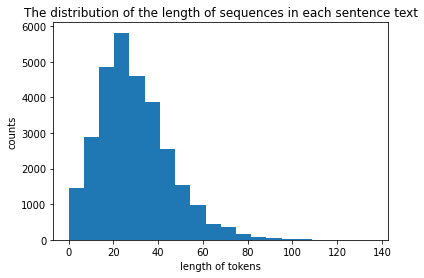

In [10]:

fp = 'dataset/MathQA4project/00_train.csv'
df = pd.read_csv(fp, index_col=0)
norm_df = sum_norm(df)
subset, ans = get_valid_subset(norm_df)
# problems 
problems = problem_processing(subset['Problem'])

# text and numbers
text = problems.apply(separate_text)
numbers = problems.apply(separate_numbers)

# text seq
# tok, x_train_seq = text_process(text)
tok_test, x_seq = text_process(text)
sequence_length = 60
x = pad_text_seq(x_seq, sequence_length)


# get the length and max length of text sequence in each sentence
seq_length = list()
max_seq = 0
for i in x_seq:
    seq_length.append(len(i))
max_seq = max(seq_length)
print("max sequence length: ", max_seq)

# get the distribution of the length of sequence in each sentence text
plt.title("The distribution of the length of sequences in each sentence text")
plt.hist(seq_length, bins=20)
plt.xlabel("length of tokens")
plt.ylabel("counts")
plt.xticks(np.arange(0, 150, 20))
plt.show()

y = ans

### processing numbers ###

In [11]:
def minmax_norm(a):
    # min-max normailise the sequence of numbers
    norm_a = np.empty(a.shape)
    for i in range(len(a)):
        maxitem = np.max(a[i, :])
        minitem = np.min(a[i, :])
        norm_a[i, :] = (a[i, :] - minitem) / (maxitem - minitem + 0.0000001)
    return norm_a

def pad_num_seq(numbers, numbers_length):
    # pad sequence (get the first 5 nubmers)
    max_number_seq = 5
    x_train_num = sequence.pad_sequences(numbers, dtype='float', truncating='post', padding='post')
    x_train_num = x_train_num[:, :numbers_length]
    return x_train_num

max number sequence length:  23


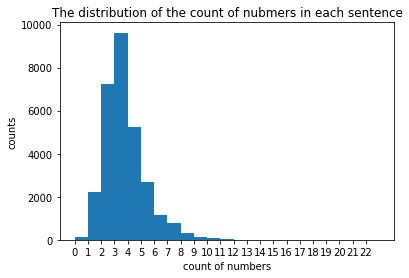

In [12]:
# the counts of the numbers in each sentence, get the distribution
max_number_seq = 0
num_seq_length = list()
for i in numbers:
    num_seq_length.append(len(i))
max_number_seq = max(num_seq_length)
print("max number sequence length: ", max_number_seq)


numbers_length = 5
x_num  = pad_num_seq(numbers, numbers_length)
norm_x_num = minmax_norm(x_num)

    
# get the distribution of the count of the nubmers
plt.title("The distribution of the count of nubmers in each sentence")
plt.hist(num_seq_length, bins=max_number_seq)
plt.xlabel("count of numbers")
plt.ylabel("counts")
plt.xticks(np.arange(max_number_seq))
plt.show()

### convert the dataset to the model input

In [13]:
def dataset_convert(c, label):
    # get pre-trained data according to the label
    
    if label == '':
        fp = 'dataset/MathQA4project/00_'+c+'.csv'
    else:
        fp = 'dataset/MathQA4project/'+c+'_'+label+'.csv'
    print(fp)

    df = pd.read_csv(fp, index_col=0)
    norm_df = sum_norm(df)
    subset, ans = get_valid_subset(norm_df)
    # problems 
    problems = problem_processing(subset['Problem'])
    
    # text and numbers
    text = problems.apply(separate_text)
    numbers = problems.apply(separate_numbers)
    
    # text seq
    tok, x_seq = text_process(text)
    sequence_length = 60
    x = pad_text_seq(x_seq, sequence_length)
    # numbers seq
#     norm_num = num_process(numbers)
    numbers_length = 5
    x_num = pad_num_seq(numbers, numbers_length)
    norm_x_num = minmax_norm(x_num)
    
    # ans series
    y = ans
    
    return subset, tok, x, norm_x_num, y, sequence_length, numbers_length

In [14]:
subset_train, tok, x_train, norm_x_train_num, y_train, sequence_length, numbers_length = dataset_convert('train', '')
subset_train

dataset/MathQA4project/00_train.csv
the max tokens in the texts:  745
token vocab length: 8096


,Problem,correct,category,option_a,option_b,option_c,option_d,option_e
0,the banker ' s gain of a certain sum due 3 yea...,0,gain,0.258065,0.193548,0.322581,0.225806,NaN
1,average age of students of an adult school is ...,3,general,0.625000,0.062500,0.187500,0.125000,NaN
2,sophia finished 2 / 3 of a book . she calculat...,1,general,0.119085,0.140406,0.456058,0.138326,0.146126
3,120 is what percent of 50 ?,1,gain,0.006274,0.301129,0.062735,0.002509,0.627353
4,there are 10 girls and 20 boys in a classroom ...,0,other,0.283030,0.188667,0.113212,0.188667,0.226424
...,...,...,...,...,...,...,...,...
29676,a man invests some money partly in 10 % stock ...,0,other,0.199724,0.224712,0.266299,0.309264,NaN
29677,"average of 10 matches is 32 , how many runs on...",3,general,0.170732,0.185366,0.190244,0.239024,0.214634
29678,solve below question 2 x + 1 = - 23,2,general,-0.177778,-0.200000,-0.266667,-0.088889,0.266667
29679,calculate 85184 ÷ ? = 352,1,general,0.198517,0.199341,0.200988,0.203460,0.197694


In [15]:
subset_train.groupby(['category']).count()

,Problem,correct,option_a,option_b,option_c,option_d,option_e
category,,,,,,,
gain,5103,5103,5103,5103,5103,5088,4549
general,13193,13193,13173,13181,13184,13135,12197
geometry,2090,2090,2087,2087,2082,2078,1880
other,1807,1807,1806,1807,1806,1806,1702
physics,7039,7039,7027,7037,7038,7025,6459
probability,449,449,448,449,448,448,424


## 5. Model

In [16]:
# Load Glove vectors

import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, errors='ignore') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 300
glove_vec_file = 'dataset/glove.6B.300d.txt'
embedding_matrix = create_embedding_matrix(glove_vec_file, tok.word_index, embedding_dim)

In [17]:
vocab_size = len(tok.word_index) + 1
print(vocab_size)
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements)
print(nonzero_elements / vocab_size)
print(embedding_matrix.shape)

8097
7572
0.9351611708040015
(8097, 300)


### building model ###

In [18]:
LSTM_DIM = 32
DROPOUT = 0.2
ACTIVATION = 'relu'
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
LOSS = tf.keras.losses.MeanSquaredError()
HIDDEN_DIM = 16

from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Embedding, LSTM, Bidirectional, Input
from keras.layers.merge import concatenate
from keras.layers import LayerNormalization

def buildModel(vsize, inputdim, maxlen, emb_matrix, maxnumbers):

    text_input = Input(shape=(maxlen, ))     
    numerical_input = Input(shape=(maxnumbers, ))
    
    emb = Embedding(input_dim=vsize, 
                   output_dim=inputdim, 
                   weights=[emb_matrix],
                   trainable=False)(text_input)

    z = LSTM(LSTM_DIM)(emb)

    z = Dropout(DROPOUT)(z)
    
    z = Dense(HIDDEN_DIM, activation=ACTIVATION)(z)
    
    
    numerical_input = Input(shape=(maxnumbers, ))
    
    merged = concatenate([z, numerical_input])    
    predictions = Dense(1, activation='linear')(merged)
    
    model = Model([text_input, numerical_input], outputs=predictions)
    
    model.compile(optimizer=OPTIMIZER,
                  loss = LOSS,
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    
    return model

model = buildModel(vocab_size, embedding_dim, sequence_length, embedding_matrix, numbers_length)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 300)      2429100     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 32)           42624       embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 32)           0           lstm[0][0]                       
______________________________________________________________________________________________

In [19]:
EPOCHS = 10
BATCH_SIZE = 50
subindex1 = 0
subindex2 = 500

m = model.fit(
#     x=[x_train[subindex1:subindex2], norm_x_train_num[subindex1:subindex2]],
#     y=y_train[subindex1:subindex2],
    x=[x_train, norm_x_train_num],
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=True,
)

Epoch 1/10
594/594 [==============================] - 19s 30ms/step - loss: 0.0971 - rmse: 0.3117
Epoch 2/10
594/594 [==============================] - 17s 28ms/step - loss: 0.0424 - rmse: 0.2059
Epoch 3/10
594/594 [==============================] - 17s 29ms/step - loss: 0.0349 - rmse: 0.1868
Epoch 4/10
594/594 [==============================] - 16s 27ms/step - loss: 0.0293 - rmse: 0.1712
Epoch 5/10
594/594 [==============================] - 16s 27ms/step - loss: 0.0249 - rmse: 0.1577
Epoch 6/10
594/594 [==============================] - 15s 26ms/step - loss: 0.0214 - rmse: 0.1461
Epoch 7/10
594/594 [==============================] - 15s 26ms/step - loss: 0.0187 - rmse: 0.1369
Epoch 8/10
594/594 [==============================] - 16s 28ms/step - loss: 0.0168 - rmse: 0.1295
Epoch 9/10
594/594 [==============================] - 17s 28ms/step - loss: 0.0154 - rmse: 0.1242
Epoch 10/10
594/594 [==============================] - 16s 27ms/step - loss: 0.0145 - rmse: 0.1203


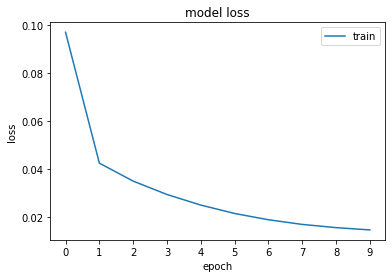

In [20]:
# show the loss
plt.plot(m.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0, EPOCHS))
plt.legend(['train'], loc='upper right')
plt.show()

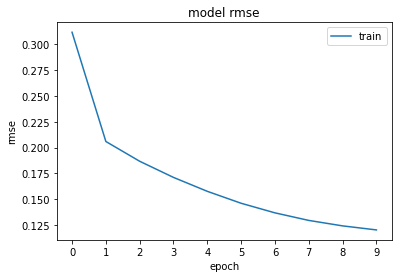

In [21]:
# show the loss
plt.plot(m.history['rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.xticks(np.arange(0, EPOCHS))
plt.legend(['train'], loc='upper right')
plt.show()

## 6. Evaluate the model

## 7. Make predictions

In [22]:
output = model.predict([x, norm_x_num])
print(output.shape)
output

(29681, 1)


array([[0.24822037],
       [0.19303994],
       [0.25635234],
       ...,
       [0.18225004],
       [0.20430203],
       [0.20907654]], dtype=float32)

In [23]:
# model.predict()

def prediction(model, c, label):
    #compute the distance between predict output and options
    
    test_df, tok, x_test, norm_x_test_num, y_test, sequence_length, numbers_length = dataset_convert(c, label)
    predict_output = model.predict([x_test, norm_x_test_num]) 
    
    opt_label = ['option_a', 'option_b', 'option_c', 'option_d']
    for i in range(len(test_df)):        
        opt_value = test_df.loc[i, opt_label]
        dist = np.abs(predict_output[i]-opt_value)
        ans_index = np.argmin(dist)        
        test_df.loc[i, 'pred'] = int(ans_index)
       
    return test_df

In [24]:
print(sequence_length)
print(numbers_length)

# predict output -> the predict answer
pred_test_df = prediction(model, 'test', '')
pred_test_df

60
5
dataset/MathQA4project/00_test.csv
the max tokens in the texts:  523
token vocab length: 4025


,Problem,correct,category,option_a,option_b,option_c,option_d,option_e,pred
0,a shopkeeper sold an article offering a discou...,0,gain,0.397178,0.289261,0.313562,NaN,NaN,1.0
1,what will be the difference between simple and...,0,gain,0.195159,0.196672,0.187595,0.201210,0.219365,3.0
2,there are 28 stations between hyderabad and ba...,2,physics,0.081039,0.086753,0.451948,0.182857,0.197403,3.0
3,the present population of a town is 3888 . pop...,4,gain,0.173611,0.145833,0.243056,0.250000,0.187500,2.0
4,the triplicate ratio of 1 : 9 is ?,4,other,0.636618,0.070728,0.079577,0.212185,0.000891,3.0
...,...,...,...,...,...,...,...,...,...
2969,find the area of a parallelogram with base 20 ...,2,geometry,0.052576,0.131441,0.420610,0.155626,0.239748,3.0
2970,"in a garden , there are 10 rows and 14 columns...",4,physics,0.166667,0.183333,0.200000,0.216667,0.233333,0.0
2971,a can do a piece of work in 6 hours ; b and c ...,3,physics,0.177778,0.133333,0.311111,0.266667,0.111111,0.0
2972,a train 250 m long running at 72 kmph crosses ...,0,physics,0.255474,0.145985,0.182482,0.197080,0.218978,3.0


## 8. Accuarcy

In [25]:
# get accuracy of the prediction
def get_acc(pred_test_df):
    cor_count = len(pred_test_df[ pred_test_df['correct'] == pred_test_df['pred'] ])
    total_count = len(pred_test_df)
    ACC =  cor_count / total_count
    return cor_count, total_count, ACC
    
    
cor_count, total_count, ACC = get_acc(pred_test_df)    

print('correct count:', cor_count)
print('total count:', total_count)
print("Accuracy: ", ACC)

correct count: 619
total count: 2974
Accuracy:  0.20813718897108271


## 9. categorise

1. construct a lexicon of n-grams relating to six specific domains.
2. compute the frequency of the domain related lexicons and then label the category of the problem
3. train and predict the model

In [26]:
# train model with categories

cat_label = ['gain', 'general', 'geometry', 'physics', 'probability', 'other']

In [27]:
def train_cat(label):
    # train cat dataset and get the models
    
    subset_train, tok, x_train, norm_x_train_num, y_train, sequence_length, numbers_length = dataset_convert('train', label)
    
    # create embedding matrix
    embedding_dim = 300
    glove_vec_file = 'dataset/glove.6B.300d.txt'
    embedding_matrix = create_embedding_matrix(glove_vec_file, tok.word_index, embedding_dim)

    vocab_size = len(tok.word_index) + 1
    print("vocab_size: ", vocab_size)
#     nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))

    # create model
    model = buildModel(vocab_size, embedding_dim, sequence_length, embedding_matrix, numbers_length)
    
    # train the model with cat
    m = model.fit(
        x=[x_train, norm_x_train_num],
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=True,
    )
    
    return model, m
    

In [28]:
model_list = list()
m_list = list()
pred_test_df_list = list()
cor_count_list = list()
total_count_list = list()
ACC_list = list()

i = 0
for label in cat_label:
    print(label)
    model, m = train_cat(label)
    model_list.append(model)
    m_list.append(m)

    pred_test_df = prediction(model, 'test', label)
    pred_test_df_list.append(pred_test_df)
    cor_count, total_count, ACC = get_acc(pred_test_df)
    print('correct count:', cor_count)
    print('total count:', total_count)
    print("Accuracy: ", ACC)
    
    cor_count_list.append(cor_count)
    total_count_list.append(total_count)
    ACC_list.append(ACC)
    
    i += 1
    print('\n*********************\n')
    
#     return model, m, pred_test_df, ACC

gain
dataset/MathQA4project/train_gain.csv
the max tokens in the texts:  580
token vocab length: 2467
vocab_size:  2468
Epoch 1/10
103/103 [==============================] - 4s 25ms/step - loss: 0.0839 - rmse: 0.2897
Epoch 2/10
103/103 [==============================] - 3s 29ms/step - loss: 0.0583 - rmse: 0.2415
Epoch 3/10
103/103 [==============================] - 3s 30ms/step - loss: 0.0481 - rmse: 0.2194
Epoch 4/10
103/103 [==============================] - 3s 28ms/step - loss: 0.0405 - rmse: 0.2012
Epoch 5/10
103/103 [==============================] - 3s 26ms/step - loss: 0.0355 - rmse: 0.1885
Epoch 6/10
103/103 [==============================] - 3s 28ms/step - loss: 0.0324 - rmse: 0.1799
Epoch 7/10
103/103 [==============================] - 3s 28ms/step - loss: 0.0292 - rmse: 0.1708
Epoch 8/10
103/103 [==============================] - 3s 27ms/step - loss: 0.0272 - rmse: 0.1650
Epoch 9/10
103/103 [==============================] - 3s 26ms/step - loss: 0.0255 - rmse: 0.1598
Epoch 1

In [29]:
for i in range(len(cat_label)):
    print("label: ", cat_label[i])
    print('correct count: ', cor_count_list[i])
    print('total count: ', total_count_list[i])
    print("Accuracy: ", ACC_list[i])
    print('************************************')

label:  gain
correct count:  124
total count:  557
Accuracy:  0.22262118491921004
************************************
label:  general
correct count:  279
total count:  1296
Accuracy:  0.2152777777777778
************************************
label:  geometry
correct count:  44
total count:  200
Accuracy:  0.22
************************************
label:  physics
correct count:  171
total count:  698
Accuracy:  0.24498567335243554
************************************
label:  probability
correct count:  9
total count:  52
Accuracy:  0.17307692307692307
************************************
label:  other
correct count:  43
total count:  171
Accuracy:  0.25146198830409355
************************************


In [30]:
print("correct count", sum(cor_count_list))
print("total count", sum(total_count_list))
print(sum(cor_count_list) / sum(total_count_list))

correct count 670
total count 2974
0.22528581035642234


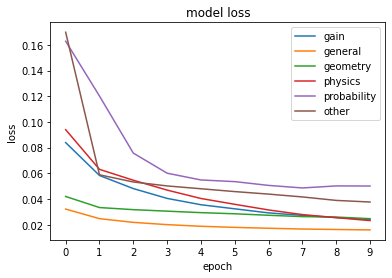

In [31]:
# show the loss

for i in range(len(m_list)):
    plt.plot(m_list[i].history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.xticks(np.arange(0, EPOCHS))

plt.legend(cat_label, loc='upper right')
plt.show()

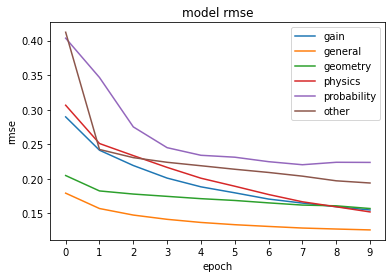

In [32]:
# show the loss

for i in range(len(m_list)):
    plt.plot(m_list[i].history['rmse'])
    plt.title('model rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.xticks(np.arange(0, EPOCHS))

plt.legend(cat_label, loc='upper right')
plt.show()